## Connecting Datasets

### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy import inspect
import geopandas
import geopandas.tools
from shapely.geometry import Point
import pickle
cnx = create_engine('postgresql://matthewmurray@52.53.245.4/policedata')
%matplotlib inline

### Collect and preprocess data

Run SQL query to collect all 196,000 rows of data from the database on AWS, then tidy up the column names

In [2]:
df = pd.read_sql_query('''SELECT * FROM incidents''', cnx)

In [3]:
df.columns

Index(['incident_num', 'category', 'description', 'day_of_week',
       'indicent_date', 'incident_time', 'pd_district', 'resolution',
       'address', 'x', 'y', 'location', 'pd_id'],
      dtype='object')

In [4]:
df.rename(columns={'incident_num':'incident_num','category':'category',
                   'description':'description','day_of_week':'day_of_week',
                   'indicent_date':'incident_date','incident_time':'incident_time',
                   'pd_district':'pd_district','resolution':'resolution',
                   'address':'address','x':'longitude','y':'latitude',
                   'location':'location','pd_id':'pd_id'}, inplace=True)

In [5]:
df.head(2)

,incident_num,category,description,day_of_week,incident_date,incident_time,pd_district,resolution,address,longitude,latitude,location,pd_id
0,170007304.0,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Tuesday,2017-01-03,17:40:00,MISSION,NONE,3700 Block of 17TH ST,-122.429634,37.762765,"(37.7627651977237,-122.429633638174)",1.700000e+13
1,170007326.0,NON-CRIMINAL,"DEATH REPORT, NATURAL CAUSES",Tuesday,2017-01-03,18:07:00,SOUTHERN,NONE,HARRISON ST / ESSEX ST,-122.394105,37.785151,"(37.785150776928,-122.394104744923)",1.700000e+13


Combine the incident date and incident time columns into a combined date_time column, then create new columns for the hour of the day and month of the incident.

In [6]:
df['date_time'] = df.apply(lambda r : pd.datetime.combine(r['incident_date'],
                                                          r['incident_time']),1)
df['hour_of_day'] = [r.hour for r in df['date_time']]
df['month'] = df['date_time'].apply(lambda x: dt.datetime.strftime(x,'%b'))

Finally, remove the unnecessary columns that I won't be using.

In [7]:
df.drop(['incident_num','incident_date','incident_time','location','pd_id'], axis=1, inplace=True)
df.sample(2)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,month
60963,ASSAULT,THREATENING PHONE CALL(S),Wednesday,SOUTHERN,NONE,1600 Block of MISSION ST,-122.419230,37.772033,2016-03-30 09:00:00,9,Mar
55937,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,NORTHERN,NONE,1300 Block of WEBSTER ST,-122.431046,37.783030,2016-03-28 16:40:00,16,Mar


### Feature engineering

There are too many individual categories, so I will bucket them into broader categories.

In [8]:
def rename_categories(input_val):
    if input_val in ['SEX OFFENSES, FORCIBLE','SEX OFFENSES, NON FORCIBLE','ROBBERY',
                     'ASSAULT','KIDNAPPING','SUICIDE','EXTORTION','BRIBERY','MISSING PERSON']:
        return 'OFFENSES AGAINST THE PERSON'
    elif input_val in ['BAD CHECKS','EMBEZZLEMENT','FORGERY/COUNTERFEITING','FRAUD']:
        return 'WHITE COLLAR CRIME'
#     elif input_val in ['LARCENY/THEFT','VEHICLE THEFT']:
#         return 'THEFT'
    elif input_val in ['BURGLARY','ARSON','VANDALISM','STOLEN PROPERTY','TRESPASS']:
        return 'PROPERTY CRIME'
    elif input_val in ['DRUG/NARCOTIC','PROSTITUTION','GAMBLING','PORNOGRAPHY/OBSCENE MAT',
                       'DISORDERLY CONDUCT','DRUNKENNESS','DRIVING UNDER THE INFLUENCE',
                       'LIQUOR LAWS']:
        return 'SOCIAL ORDER OFFENSES'
    elif input_val == 'SECONDARY CODES':
        return 'DOMESTIC VIOLENCE AND JUVENILE CRIME'
    elif input_val in ['SUSPICIOUS OCC','LOITERING','TREA']:
        return 'SUSPICIOUS BEHAVIOR'
    elif input_val in ['RUNAWAY','FAMILY OFFENSES','RECOVERED VEHICLE','WEAPON LAWS',
                       'WARRANTS']:
        return 'OTHER OFFENSES'
    else:
        return input_val

df['broad_category'] = df['category'].apply(rename_categories)

Remove some categories that are not useful geography-wise

In [9]:
df = df[df['broad_category'] != 'SUSPICIOUS BEHAVIOR']
df = df[df['broad_category'] != 'OTHER OFFENSES']
df = df[df['broad_category'] != 'NON-CRIMINAL']
df = df[df['broad_category'] != 'WHITE COLLAR CRIME']

I will be doing a lot of geospatial data processing, so I will convert the latitude and longitude columns into Points using Shapely. I will also create an arbitrary 'id' column so that I have a 'primary key' to be able to work with, should I ever need it.

In [10]:
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
df['id'] = df.index
df.sample(2)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,month,broad_category,geometry,id
57913,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Saturday,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2016-04-02 02:00:00,2,Apr,PROPERTY CRIME,POINT (-122.4034048 37.77542071),57913
32960,ARSON,ARSON OF AN INHABITED DWELLING,Monday,TARAVAL,NONE,100 Block of CAMBON DR,-122.474171,37.716657,2017-04-17 19:01:00,19,Apr,PROPERTY CRIME,POINT (-122.474171 37.71665697),32960


#### Geospatial data

First up is to connect the zip code + population geospatial data that I downloaded from the SF open data website. I will be using geopandas to work with all of my geospatial data.

In [11]:
zip_df = geopandas.read_file('zip.geojson')
zip_df.drop(['id','multigeom','objectid','po_name','st_area_sh','st_length_','state',
             'zip'], axis=1, inplace=True)

In [12]:
zip_df.sample(5)

,geometry,pop10_sqmi,pop2010,sqmi,zip_code
2,POLYGON ((-122.4555040090645 37.76091139152248...,11153.0,24202,2.17,94131
13,POLYGON ((-122.3917009776518 37.79411300167845...,46226.7,20802,0.45,94105
7,"POLYGON ((-122.3908201190462 37.7766660063356,...",9522.0,4761,0.5,94158
29,POLYGON ((-122.4244074100221 37.81072189731741...,19925.4,22715,1.14,94123
3,"POLYGON ((-122.486279012768 37.73682097594768,...",6440.6,26986,4.19,94132


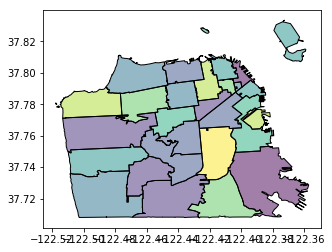

In [13]:
zip_df.plot()

In [14]:
# create a GeoDataFrame of the geometry data from the original data-set
gdf = geopandas.GeoDataFrame(df[['id','geometry']], geometry='geometry')
gdf.crs = {"init": "epsg:4326"}
gdf.sample(2)

,id,geometry
146322,146322,POINT (-122.4815173 37.78117781)
163259,163259,POINT (-122.4039949 37.79461182)


In [15]:
# do a spatial join on the two GeoDataFrames
result = geopandas.tools.sjoin(gdf, zip_df, how='left')
result.drop(['geometry','index_right'], axis=1, inplace=True)
result.sample(2)

,id,pop10_sqmi,pop2010,sqmi,zip_code
61875,61875,22830.1,30364,1.33,94103
10752,10752,6440.6,26986,4.19,94132


In [16]:
# reconnect with original data-set
df = df.merge(result, left_on='id', right_on='id')
df['zip_code'] = df['zip_code'].apply(lambda x: str(x))
df.head(2)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,month,broad_category,geometry,id,pop10_sqmi,pop2010,sqmi,zip_code
0,ASSAULT,BATTERY,Tuesday,TARAVAL,"ARREST, BOOKED",3200 Block of 20TH AV,-122.475647,37.728528,2017-01-03 17:43:00,17,Jan,OFFENSES AGAINST THE PERSON,POINT (-122.4756475 37.72852806),2,6440.6,26986,4.19,94132
1,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Tuesday,TARAVAL,"ARREST, BOOKED",3200 Block of 20TH AV,-122.475647,37.728528,2017-01-03 17:43:00,17,Jan,LARCENY/THEFT,POINT (-122.4756475 37.72852806),3,6440.6,26986,4.19,94132


#### Income data

Next task is to connect the median income by zip code data that I downloaded from another source.

In [17]:
income_df = pd.read_csv('median_income_data.csv')
income_df.drop(['latitude','longitude','population'], axis=1, inplace=True)
income_df['median_income'] = income_df['median_income'].apply(lambda x: float(str(x).replace(',','')))
income_df['zip_code'] = income_df['zip_code'].apply(lambda x: str(x))
income_df.head(2)

,zip_code,median_income
0,94127,95313.0
1,94105,88976.0


In [18]:
df = df.merge(income_df, left_on='zip_code', right_on='zip_code', how='left')
df.head(2)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,month,broad_category,geometry,id,pop10_sqmi,pop2010,sqmi,zip_code,median_income
0,ASSAULT,BATTERY,Tuesday,TARAVAL,"ARREST, BOOKED",3200 Block of 20TH AV,-122.475647,37.728528,2017-01-03 17:43:00,17,Jan,OFFENSES AGAINST THE PERSON,POINT (-122.4756475 37.72852806),2,6440.6,26986,4.19,94132,55000.0
1,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Tuesday,TARAVAL,"ARREST, BOOKED",3200 Block of 20TH AV,-122.475647,37.728528,2017-01-03 17:43:00,17,Jan,LARCENY/THEFT,POINT (-122.4756475 37.72852806),3,6440.6,26986,4.19,94132,55000.0


I also have average house price (Z index) data from retrieved from the Zillow API..

#### Zillow API Data

In [19]:
zillow_df = pickle.load(open('z_index_data.pkl', 'rb'))
zillow_df['zip_code'] = zillow_df['zip_code'].apply(lambda x: str(x))
zillow_df.head(3)

,zip_code,z_index
0,94102,703800.0
1,94103,913350.0
2,94105,1193700.0


In [20]:
df = df.merge(zillow_df, left_on='zip_code', right_on='zip_code', how='left')
df.sample(2)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,month,broad_category,geometry,id,pop10_sqmi,pop2010,sqmi,zip_code,median_income,z_index
25547,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,CENTRAL,NONE,100 Block of NORTHPOINT ST,-122.409724,37.807115,2017-03-10 20:00:00,20,Mar,LARCENY/THEFT,POINT (-122.4097236 37.80711542),40328,34200.0,24966,0.73,94133,40990.0,1.036800e+06
27355,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,3000 Block of PACIFIC AV,-122.445504,37.792035,2017-04-12 22:00:00,22,Apr,LARCENY/THEFT,POINT (-122.4455045 37.79203536),42310,25896.4,28486,1.1,94115,54879.0,1.160933e+06


Now to calculate the distance (distance = euclidean distance) of each police incident to the nearest BART or Caltrain station...

#### BART / Caltrain stations

In [21]:
station_locations = pickle.load(open('station_locations.pkl', 'rb'))

In [22]:
df.sample(2)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,month,broad_category,geometry,id,pop10_sqmi,pop2010,sqmi,zip_code,median_income,z_index
117964,PROSTITUTION,SOLICITS FOR ACT OF PROSTITUTION,Friday,SOUTHERN,NONE,100 Block of 3RD ST,-122.400916,37.785457,2016-01-29 20:35:00,20,Jan,SOCIAL ORDER OFFENSES,POINT (-122.400916 37.78545749),184597,22830.1,30364,1.33,94103,31131.0,913350.0
115193,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,TARAVAL,NONE,2300 Block of 24TH AV,-122.481183,37.743727,2016-03-16 14:00:00,14,Mar,LARCENY/THEFT,POINT (-122.4811832 37.74372682),179791,16360.7,42865,2.62,94116,66627.0,1153700.0


In [23]:
def min_distance_to_station(point):
    return station_locations.distance(point).min()

def num_close_stations(point):
    distances = station_locations.distance(point)
    counter = 0
    for d in distances:
        if d < 0.01:
            counter += 1
    return counter

df['dist_to_train_station'] = df['geometry'].apply(min_distance_to_station)
df['num_close_train_stations'] = df['geometry'].apply(num_close_stations)

In [24]:
df.sample(5)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,...,geometry,id,pop10_sqmi,pop2010,sqmi,zip_code,median_income,z_index,dist_to_train_station,num_close_train_stations
15758,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",Thursday,RICHMOND,"ARREST, BOOKED",800 Block of LA PLAYA ST,-122.509895,37.772313,2017-03-30 16:35:00,16,...,POINT (-122.5098954 37.7723132),26939,18809.6,41193,2.19,94121,61776.0,2085900.0,0.080410,0
108578,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Saturday,MISSION,NONE,22ND ST / HAMPSHIRE ST,-122.407605,37.756110,2016-11-05 22:06:00,22,...,POINT (-122.4076048 37.75610979),170474,27982.9,67159,2.4,94110,53795.0,1095100.0,0.011149,0
110358,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2016-11-27 20:40:00,20,...,POINT (-122.4034048 37.77542071),172476,22830.1,30364,1.33,94103,31131.0,913350.0,0.009013,1
85895,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,Wednesday,BAYVIEW,NONE,2900 Block of HAWES ST,-122.391431,37.717810,2016-12-07 22:30:00,22,...,POINT (-122.3914312 37.71780992),142016,7645.4,37233,4.87,94124,37146.0,612900.0,0.014725,0
66647,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Monday,INGLESIDE,NONE,5800 Block of MISSION ST,-122.451819,37.709154,2016-09-05 13:15:00,13,...,POINT (-122.4518185 37.70915421),109557,25086.1,82784,3.3,94112,57629.0,796450.0,0.013158,0


#### Distance to the nearest police station

In [25]:
police_locations = pickle.load(open('police_locations.pkl', 'rb'))
police_locations

,geometry
0,POINT (-122.4099186 37.7987322)
1,POINT (-122.3894121 37.7723802)
2,POINT (-122.3979806 37.7297322)
3,POINT (-122.422005 37.762849)
4,POINT (-122.4324665 37.7801858)
5,POINT (-122.455287 37.767797)
6,POINT (-122.4644668 37.7799276)
7,POINT (-122.4462154 37.7246756)
8,POINT (-122.4815003 37.7437335)
9,POINT (-122.4128962 37.783669)


In [26]:
def min_distance_to_police(point):
    return police_locations.distance(point).min()

def num_close_police_stations(point):
    distances = police_locations.distance(point)
    counter = 0
    for d in distances:
        if d < 0.01:
            counter += 1
    return counter

df['dist_to_police_station'] = df['geometry'].apply(min_distance_to_police)
df['num_close_police_stations'] = df['geometry'].apply(num_close_police_stations)

In [27]:
df.sample(2)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,...,pop10_sqmi,pop2010,sqmi,zip_code,median_income,z_index,dist_to_train_station,num_close_train_stations,dist_to_police_station,num_close_police_stations
74522,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Thursday,RICHMOND,NONE,1000 Block of POINTLOBOS AV,-122.513642,37.778469,2016-10-13 17:00:00,17,...,18809.6,41193,2.19,94121,61776.0,2085900.0,0.087234,0,0.047325,0
24998,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Saturday,CENTRAL,NONE,2300 Block of STOCKTON ST,-122.410525,37.807445,2017-03-04 13:00:00,13,...,34200.0,24966,0.73,94133,40990.0,1036800.0,0.019867,0,0.008734,1


#### Dispensary location data

In [28]:
dispensary_locations = pickle.load(open('dispensary_locations.pkl', 'rb'))
dispensary_locations.head()

,geometry
0,POINT (-122.4194132797827 37.78662965327916)
1,POINT (-122.4298778642076 37.77189194436477)
2,POINT (-122.4385234945558 37.77606702194213)
3,POINT (-122.4711317429206 37.7804004970458)
4,POINT (-122.4635424309064 37.72602894819491)


In [29]:
def min_distance_to_dispensary(point):
    return dispensary_locations.distance(point).min()

def num_close_dispensaries(point):
    distances = dispensary_locations.distance(point)
    counter = 0
    for d in distances:
        if d < 0.01:
            counter += 1
    return counter

df['dist_to_dispensary'] = df['geometry'].apply(min_distance_to_dispensary)
df['num_close_dispensaries'] = df['geometry'].apply(num_close_dispensaries)

In [30]:
df.sample(2)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,...,sqmi,zip_code,median_income,z_index,dist_to_train_station,num_close_train_stations,dist_to_police_station,num_close_police_stations,dist_to_dispensary,num_close_dispensaries
77694,ASSAULT,BATTERY,Thursday,SOUTHERN,NONE,3RD ST / BRANNAN ST,-122.394305,37.780091,2016-10-20 13:40:00,13,...,1.86,94107,61362.0,1059450.0,0.003704,1,0.009132,1,0.007937,2
76835,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Tuesday,CENTRAL,NONE,1400 Block of WASHINGTON ST,-122.417119,37.793732,2016-10-25 19:00:00,19,...,1.03,94109,43444.0,1279800.0,0.013015,0,0.008766,1,0.007464,1


#### Health care facility locations

In [31]:
care_locations = pickle.load(open('care_locations.pkl', 'rb'))
care_locations.head()

,geometry
0,POINT (-122.4535495 37.78740232)
1,POINT (-122.45591166 37.78614406)
2,POINT (-122.4358177 37.76905419)
3,POINT (-122.43103755 37.79142444)
4,POINT (-122.42124885 37.74804296)


In [32]:
def min_distance_to_health_facility(point):
    return care_locations.distance(point).min()


def num_close_health_facilities(point):
    distances = care_locations.distance(point)
    counter = 0
    for d in distances:
        if d < 0.01:
            counter += 1
    return counter

df['dist_to_health_facility'] = df['geometry'].apply(min_distance_to_health_facility)
df['num_close_health_facilities'] = df['geometry'].apply(num_close_health_facilities)

In [33]:
df.sample(2)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,...,median_income,z_index,dist_to_train_station,num_close_train_stations,dist_to_police_station,num_close_police_stations,dist_to_dispensary,num_close_dispensaries,dist_to_health_facility,num_close_health_facilities
35559,VANDALISM,"MALICIOUS MISCHIEF, STREET CARS/BUSES",Sunday,INGLESIDE,NONE,CORTLAND AV / MISSION ST,-122.422842,37.741029,2016-03-27 21:20:00,21,...,53795.0,1095100.0,0.012369,0,0.021836,0,0.003047,2,0.002529,7
48318,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,RICHMOND,NONE,30TH AV / FULTON ST,-122.489539,37.772325,2016-05-31 17:00:00,17,...,61776.0,2085900.0,0.065888,0,0.026199,0,0.020101,0,0.008775,1


In [34]:
df.columns

Index(['category', 'description', 'day_of_week', 'pd_district', 'resolution',
       'address', 'longitude', 'latitude', 'date_time', 'hour_of_day', 'month',
       'broad_category', 'geometry', 'id', 'pop10_sqmi', 'pop2010', 'sqmi',
       'zip_code', 'median_income', 'z_index', 'dist_to_train_station',
       'num_close_train_stations', 'dist_to_police_station',
       'num_close_police_stations', 'dist_to_dispensary',
       'num_close_dispensaries', 'dist_to_health_facility',
       'num_close_health_facilities'],
      dtype='object')

#### Shelter locations

In [35]:
shelter_locations = pickle.load(open('shelter_locations.pkl', 'rb'))
shelter_locations.head()

,geometry
1,POINT (-122.4375855 37.781571)
2,POINT (-122.3933527 37.7910388)
3,POINT (-122.4072079 37.7765976)
4,POINT (-122.3990467 37.7265131)
6,POINT (-122.4141134 37.7764266)


In [36]:
def min_distance_to_shelters(point):
    return shelter_locations.distance(point).min()

def num_close_shelters(point):
    distances = shelter_locations.distance(point)
    counter = 0
    for d in distances:
        if d < 0.01:
            counter += 1
    return counter

df['dist_to_shelter'] = df['geometry'].apply(min_distance_to_shelters)
df['num_close_shelters'] = df['geometry'].apply(num_close_shelters)

In [37]:
df.sample(5)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,...,dist_to_train_station,num_close_train_stations,dist_to_police_station,num_close_police_stations,dist_to_dispensary,num_close_dispensaries,dist_to_health_facility,num_close_health_facilities,dist_to_shelter,num_close_shelters
38996,VEHICLE THEFT,STOLEN TRUCK,Wednesday,CENTRAL,NONE,CALIFORNIA ST / BATTERY ST,-122.399963,37.793209,2016-04-13 10:00:00,10,...,0.002962,2,0.011385,0,0.005006,2,0.006542,3,0.001134,8
35865,VEHICLE THEFT,STOLEN AUTOMOBILE,Thursday,INGLESIDE,NONE,MONTEREY BL / JOOST AV,-122.434992,37.732295,2016-02-18 20:30:00,20,...,0.001404,1,0.013566,0,0.005025,1,0.005809,2,0.008457,1
95382,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Sunday,NORTHERN,NONE,LARKIN ST / MCALLISTER ST,-122.416949,37.780469,2016-04-03 07:30:00,7,...,0.002920,2,0.005164,1,0.004441,6,0.002083,20,0.001437,40
22092,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Tuesday,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2017-01-24 09:00:00,9,...,0.009013,1,0.012575,0,0.006862,3,0.003678,3,0.000950,28
97861,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Thursday,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2016-05-19 13:30:00,13,...,0.009013,1,0.012575,0,0.006862,3,0.003678,3,0.000950,28


#### Distance to Union Sq

Adding a distance to union square metric.

In [38]:
def distance_to_union_sq(point):
    return union_sq.distance(point).min()

u_sq = {'lng': [-122.4075],
        'lat': [37.788056]}

union_sq = geopandas.GeoDataFrame(u_sq)
union_sq['geometry'] = union_sq.apply(lambda row: Point(row['lng'], row['lat']), axis=1)
union_sq.drop(['lat','lng'], axis=1, inplace=True)
df['dist_to_union_sq'] = df['geometry'].apply(distance_to_union_sq)

In [39]:
df.sample(10)

,category,description,day_of_week,pd_district,resolution,address,longitude,latitude,date_time,hour_of_day,...,num_close_train_stations,dist_to_police_station,num_close_police_stations,dist_to_dispensary,num_close_dispensaries,dist_to_health_facility,num_close_health_facilities,dist_to_shelter,num_close_shelters,dist_to_union_sq
17939,ASSAULT,FALSE IMPRISONMENT,Monday,BAYVIEW,NONE,MINNESOTA ST / MARIPOSA ST,-122.390820,37.764201,2017-04-10 16:00:00,16,...,1,0.008300,1,0.022100,0,0.012699,0,0.010131,0,0.029109
116545,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Sunday,CENTRAL,NONE,2200 Block of STOCKTON ST,-122.410474,37.806496,2016-01-24 20:18:00,20,...,0,0.007783,1,0.020842,0,0.006756,3,0.011593,0,0.018678
74599,VEHICLE THEFT,STOLEN TRUCK,Friday,INGLESIDE,NONE,0 Block of PROSPECT AV,-122.417503,37.745189,2016-01-22 21:00:00,21,...,1,0.018225,0,0.002143,2,0.002780,8,0.002318,2,0.044018
97850,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Thursday,PARK,NONE,100 Block of PARNASSUS AV,-122.451880,37.764542,2016-05-19 19:20:00,19,...,0,0.004712,1,0.017642,0,0.005655,5,0.002953,5,0.050225
90864,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,HARRISON ST / 7TH ST,-122.406300,37.775513,2016-01-04 13:25:00,13,...,2,0.010489,0,0.006726,5,0.000902,6,0.001414,35,0.012600
94355,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,PARK,NONE,SCOTT ST / EDDY ST,-122.437263,37.780802,2016-03-14 08:30:00,8,...,0,0.004835,1,0.004900,1,0.001798,4,0.000834,9,0.030634
40001,ASSAULT,FALSE IMPRISONMENT,Tuesday,TENDERLOIN,"ARREST, BOOKED",300 Block of TURK ST,-122.414879,37.782634,2016-04-19 13:33:00,13,...,2,0.002237,1,0.005710,5,0.000299,19,0.000641,43,0.009157
91269,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Thursday,CENTRAL,NONE,300 Block of KEARNY ST,-122.404195,37.791226,2016-01-14 15:30:00,15,...,3,0.009440,1,0.004804,4,0.004049,7,0.002232,15,0.004579
103390,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Monday,CENTRAL,NONE,0 Block of HOTALING PL,-122.402762,37.796052,2016-08-08 09:00:00,9,...,2,0.007642,1,0.008162,1,0.002651,6,0.004377,6,0.009295
47442,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Saturday,RICHMOND,NONE,1100 Block of 9TH AV,-122.466504,37.766201,2016-05-28 09:52:00,9,...,0,0.011330,0,0.014934,0,0.008428,1,0.001650,3,0.062922


### Save dataset

In [40]:
pickle.dump(df, open('complete_data_set.pkl', 'wb'))